In [1]:
import numpy as np 
import pdb
import h5py
from scipy.linalg import svd 
import scipy
from sklearn.utils.extmath import randomized_svd
import seaborn as sns
import pandas as pd 
%load_ext rpy2.ipython
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12,12]
from plinkio import plinkfile    
_EPS = 1e-40
from scipy.stats import chi2, norm
import matplotlib.cm as cm

/home/apoursh/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
dstore = h5py.File('cleanedData/uniformSplit/five_way/_backup_PCA/DO0.h5py', 'r')

dmeta = dstore['meta']

Ucenteralized = pd.read_csv('cleanedData/centralized.txt.U.txt', delimiter=' ', header=None, prefix='PC')
countries     = pd.read_csv('cleanedData/centralized.txt.countries', delimiter='\n', header=None)

# PCA plots

In [3]:
regions = countries.values[:,0]
Us = Ucenteralized
colors = pd.read_csv('nov/Novembre_etal_2008_misc/files/ColorTablePCmap.txt', sep='\t', header=None) 
color_map = {item[0]:item[1] for item in colors.as_matrix()}

cdf = pd.DataFrame({'PC1'   :-Us.iloc[:,0], 'PC2':-Us.iloc[:,1], 'PC3':Us.iloc[:,2], 'PC4':Us.iloc[:,3],
                    'PC5'   :Us.iloc[:,4],
                    'color' :[color_map[x] for x in regions],
                    'region':regions})

## Scenario 1

In [4]:
ddf = pd.DataFrame()
for i in range(5):
    dstore.close()
    dstore = h5py.File('cleanedData/uniformSplit/five_way/_backup_PCA/DO' + str(i) + '.h5py', 'r')
    dmeta = dstore['meta']
    regions = dmeta['regions'].value
    tdf = pd.DataFrame({'PC1':dmeta['pca_u'].value[:,0], 
                    'PC2':-dmeta['pca_u'].value[:,1], 
                    'PC3':-dmeta['pca_u'].value[:,2], 
                    'PC4':-dmeta['pca_u'].value[:,3], 
                    'PC5':-dmeta['pca_u'].value[:,4], 
                    'color':[color_map[region] for region in regions],
                    'region':regions,
                    'id': dmeta['id'].value,
                    'status':dmeta['Status']})
    ddf = ddf.append(tdf)

cdf = cdf.sort_values(by=['PC1', 'PC2'])
ddf = ddf.sort_values(by=['PC1', 'PC2'])

/home/apoursh/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘cowplot’


  warnings.warn(x, RRuntimeWarning)
/home/apoursh/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:ggplot2’:

    ggsave


  warnings.warn(x, RRuntimeWarning)


TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name            grob
1 1 (1-1,1-1) arrange gtable[arrange]
2 2 (2-2,1-1) arrange gtable[arrange]
TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name            grob
1 1 (1-1,1-1) arrange gtable[arrange]
2 2 (2-2,1-1) arrange gtable[arrange]


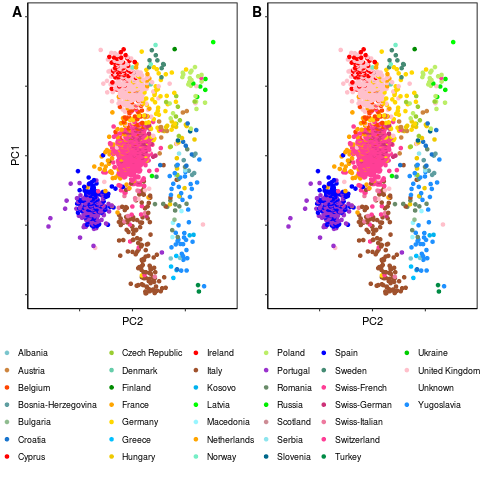

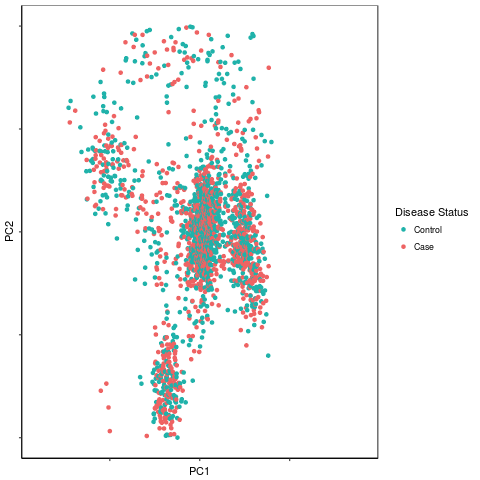

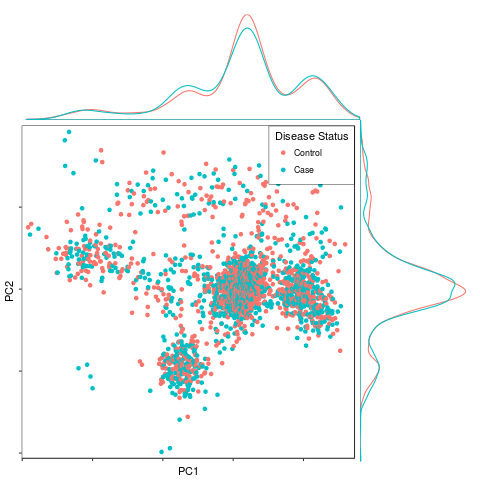

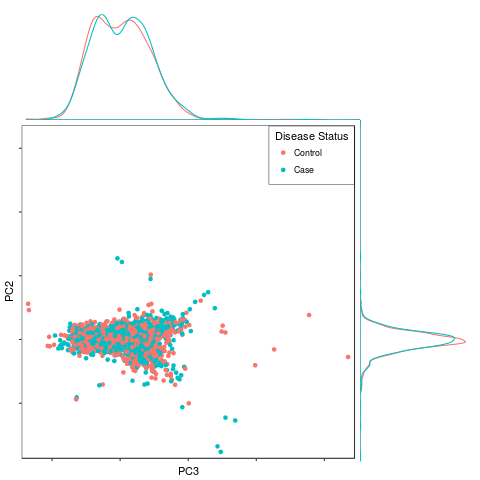

In [5]:
%%R -i colors -i cdf -i ddf 
library(repr)
options(repr.plot.width=7, repr.plot.height=7)
library(ggplot2)
library(cowplot)
library(gridExtra)


cmap = c()
for (i in 1:length(cdf$color)){
    cmap[toString(ddf$region[i])] = toString(ddf$color[i])
}
#margin = c(0,0,-1.5,.4)
xlims1 = 0.09   ; xlims2  = - 0.09
ylims1 = 0.05   ; ylims2 = -0.05

plt <- ggplot(cdf, aes(x=PC2, y=PC1)) + theme_bw()
plt <- plt +  geom_point(aes(colour = factor(cdf$region)))
plt <- plt + labs(x = "PC2", y = "PC1") 
plt <- plt + theme(legend.position="right", plot.margin = unit(c(.1,0,-3,.4), "cm"), 
                   legend.margin = margin(t = c(0,0,-3,0), unit='cm'))
plt <- plt + scale_colour_manual(values = cmap) + guides(color=guide_legend(title=element_blank(), ncol=6)) 
plt <- plt + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
plt <- plt  + ylim(ylims2, ylims1) + xlim(xlims2, xlims1)

plt2 <- ggplot(ddf, aes(x=PC2, y=PC1)) + theme_bw()
plt2 <- plt2 +  geom_point(aes(colour = factor(ddf$region)))
plt2 <- plt2 + labs(x = "PC2", y=element_blank()) 
plt2 <- plt2 + theme(legend.position="right", plot.margin = unit(c(.1,.1,-3,.4), "cm")) 
plt2 <- plt2 + scale_colour_manual(values = cmap) + guides(color=guide_legend(title=element_blank())) 
plt2 <- plt2 + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
plt2 <- plt2 + ylim(ylims2, ylims1) + xlim(xlims2, xlims1) 

prow <- plot_grid( plt + theme(legend.position="none"),
           plt2 + theme(legend.position="none"),
           align = 'vh',
           labels = c("A", "B"),
           hjust = -0.,
           nrow = 1,
           label_x=.05
           )

legend <- get_legend(plt + theme(legend.position="left")) 
p <- plot_grid( prow, legend, rel_widths = c(1, 1), scale = 1, ncol=1)

print(p)
ggsave('figures/five_way_PC1_PC2.pdf', width=8, height= 6.5) #A4 size in inches

plt3 <- ggplot(ddf, aes(x=PC1, y=PC2)) + theme_bw()
plt3 <- plt3 +  geom_point(aes(colour = factor(ddf$status))) 
plt3 <- plt3 + labs(x = "PC1", y='PC2', color='Disease Status')
plt3 <- plt3 + scale_color_manual(labels = c("Control", "Case"), values = c("lightseagreen", "indianred2"))  
plt3 <- plt3 + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
plt3 <- plt3 + ylim(ylims2, ylims1) + xlim(xlims2, xlims1) 
# plt3 <- plt3 + geom_rug(data = subset(ddf, status == 1),
#              aes(x = PC1, y=PC2), inherit.aes = F)
print(plt3)

# ddf$bins <- cut(ddf$PC1,breaks = 20)
# p = ggplot(ddf, aes(x = bins, y = status)) + stat_summary(fun.y = "mean", geom = "point")
# p <- p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
#   panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
# print(p)

p1 <- ggplot(ddf, aes(x = PC1, y = PC2, colour=factor(status))) + geom_point() +   
  scale_x_continuous(expand=c(0.02,0)) +
  scale_y_continuous(expand=c(0.02,0)) +
  theme_bw() +
  labs("PC1", y='PC2', color='Disease Status') + 
  scale_color_hue(labels=c("Control", "Case")) + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
  panel.background = element_blank(), axis.line = element_blank(), axis.text=element_blank()) + 
  theme(legend.position = c(0.871, 0.911), legend.background = 
        element_rect(color = "black", size = .2, linetype = "solid")) 

theme0 <- function(...) theme( legend.position = "none",
                               panel.background = element_blank(),
                               panel.grid.major = element_blank(),
                               panel.grid.minor = element_blank(),
                               panel.margin = unit(0,"null"),
                               axis.ticks = element_blank(),
                               axis.text.x = element_blank(),
                               axis.text.y = element_blank(),
                               axis.title.x = element_blank(),
                               axis.title.y = element_blank(),
                               axis.ticks.length = unit(0,"null"),
                               axis.ticks.margin = unit(0,"null"),
                               panel.border=element_rect(color=NA),...)
    
p2 <- ggplot(ddf,aes(x=PC1,colour=factor(status)))+#,fill=factor(status))) + 
  geom_density(alpha=0.5) +  
# p2 <- ggplot(ddf, aes(x = PC1, y=density1)) + #stat_summary(fun.y = "mean", geom = "point") + 
#   geom_line(alpha=0.5, color='black', size=1) +
  scale_x_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  scale_y_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  theme_bw() +
  theme0(plot.margin = unit(c(1,0,0,1.8),"lines")) 

p3 <- ggplot(ddf,aes(x=PC2,colour=factor(status))) + 
  geom_density(alpha=0.5) + 
# p3 <- ggplot(ddf, aes(x = PC1, y=density1)) + 
#   geom_line(alpha=0.5, color='black', size=1) + 
  coord_flip()  + 
  scale_x_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  scale_y_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  theme_bw() +
  theme0(plot.margin = unit(c(0,1,1.3,0),"lines"))
    
p = grid.arrange(arrangeGrob(p2,ncol=2,widths=c(3,1)),
             arrangeGrob(p1,p3,ncol=2,widths=c(3,1)),
             heights=c(1,3))
print(p)
    
    
p1 <- ggplot(ddf, aes(x = PC3, y = PC4, colour=factor(status))) + geom_point() +   
  scale_x_continuous(expand=c(0.02,0)) +
  scale_y_continuous(expand=c(0.02,0)) +
  theme_bw() +
  labs("PC1", y='PC2', color='Disease Status') + 
  scale_color_hue(labels=c("Control", "Case")) + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
  panel.background = element_blank(), axis.line = element_blank(), axis.text=element_blank()) + 
  theme(legend.position = c(0.871, 0.911), legend.background = 
        element_rect(color = "black", size = .2, linetype = "solid")) 
    
p2 <- ggplot(ddf,aes(x=PC3,colour=factor(status)))+#,fill=factor(status))) + 
  geom_density(alpha=0.5) +  
# p2 <- ggplot(ddf, aes(x = PC1, y=density1)) + #stat_summary(fun.y = "mean", geom = "point") + 
#   geom_line(alpha=0.5, color='black', size=1) +
  scale_x_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  scale_y_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  theme_bw() +
  theme0(plot.margin = unit(c(1,0,0,1.8),"lines")) 

p3 <- ggplot(ddf,aes(x=PC4,colour=factor(status))) + 
  geom_density(alpha=0.5) + 
# p3 <- ggplot(ddf, aes(x = PC1, y=density1)) + 
#   geom_line(alpha=0.5, color='black', size=1) + 
  coord_flip()  + 
  scale_x_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  scale_y_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  theme_bw() +
  theme0(plot.margin = unit(c(0,1,1.3,0),"lines"))
    
p = grid.arrange(arrangeGrob(p2,ncol=2,widths=c(3,1)),
             arrangeGrob(p1,p3,ncol=2,widths=c(3,1)),
             heights=c(1,3))
print(p)

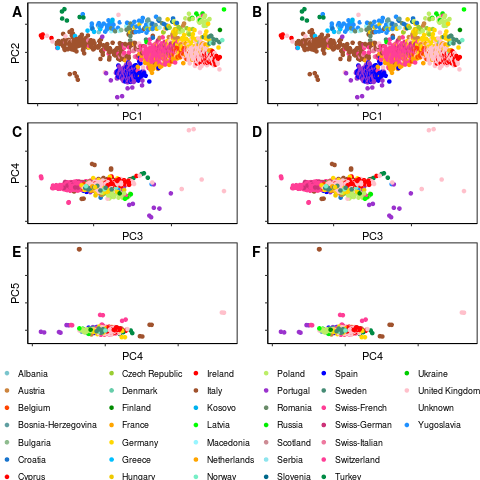

In [6]:
%%R -i colors -i cdf -i ddf 
library(repr)
options(repr.plot.width=7, repr.plot.height=7)
library(ggplot2)
library(cowplot)

cmap = c()
for (i in 1:length(cdf$color)){
    cmap[toString(ddf$region[i])] = toString(ddf$color[i])
}

plotter <- function(cdf, ddf, PC1, PC2) {
    x_upper = max(max(cdf[,PC1]), max(ddf[,PC1]))
    x_lower = min(min(cdf[,PC1]), max(ddf[,PC1]))
    gap = (x_upper - x_lower)/50
    x_upper = x_upper + gap 
    x_lower = x_lower - gap

    y_upper = max(max(cdf[,PC2]), max(ddf[,PC2]))
    y_lower = min(min(cdf[,PC2]), max(ddf[,PC2]))
    gap = (y_upper - y_lower)/50
    y_upper = y_upper + gap 
    y_lower = y_lower - gap
    
    plt12 <- ggplot(cdf, aes_string(x=PC1, y=PC2)) + theme_bw()
    plt12 <- plt12 +  geom_point(aes(colour = factor(cdf$region)))
    plt12 <- plt12 + labs(x = PC1, y = PC2) 
    plt12 <- plt12 + theme(legend.position="right", plot.margin = unit(c(.1,.1,0,.4), "cm"), 
                   legend.margin = margin(t = c(0,0,-.2,0), unit='cm'))
    plt12 <- plt12 + scale_colour_manual(values = cmap) + guides(color=guide_legend(title=element_blank(), ncol=6)) 
    plt12 <- plt12 + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
    plt12 <- plt12 + xlim(x_lower, x_upper) + ylim(y_lower, y_upper)

    dplt12 <- ggplot(ddf, aes_string(x=PC1, y=PC2)) + theme_bw()
    dplt12 <- dplt12 +  geom_point(aes(colour = factor(ddf$region)))
    dplt12 <- dplt12 + labs(x = PC1, y=element_blank())  
    dplt12 <- dplt12 + theme(legend.position="right", plot.margin = unit(c(.1,.1,0,.4), "cm")) 
    dplt12 <- dplt12 + scale_colour_manual(values = cmap) + guides(color=guide_legend(title=element_blank())) 
    dplt12 <- dplt12 + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
    dplt12 <- dplt12 + xlim(x_lower, x_upper) + ylim(y_lower, y_upper)
    return(list("plt" = plt12, "dplt" = dplt12))
}

plt <- plotter(cdf, ddf, "PC1", "PC2")
plt12 = plt$plt
dplt12 = plt$dplt

plt <- plotter(cdf, ddf, "PC3", "PC4")
plt34 = plt$plt
dplt34 = plt$dplt

plt <- plotter(cdf, ddf, "PC4", "PC5")
plt45 = plt$plt
dplt45 = plt$dplt


prow <- plot_grid( plt12 + theme(legend.position="none"),
                  dplt12 + theme(legend.position="none"),
                  plt34 + theme(legend.position="none"),
                  dplt34 + theme(legend.position="none"),
                  plt45 + theme(legend.position="none"),
                  dplt45 + theme(legend.position="none"),
           align = 'vh',
           labels = "AUTO",
           hjust = -0.,
           nrow = 3,
           label_x=.05
           )

legend <- get_legend(plt12 + theme(legend.position="left")) 
p <- plot_grid( prow, legend, rel_heights = c(3, 1), scale = 1, ncol=1)

print(p)
ggsave('figures/PCs_fiveway.pdf', width=8, height= 7)


## Scenario 2

In [7]:
store = h5py.File('cleanedData/POPRES_NoSpain.h5')
Ucenteralized = pd.read_csv('cleanedData/centralized.txt.U.txt', delimiter=' ', header=None, prefix='PC')
countries     = pd.read_csv('cleanedData/centralized.txt.countries', delimiter='\n', header=None)
regions = countries.values[:,0]
Us = Ucenteralized
colors = pd.read_csv('nov/Novembre_etal_2008_misc/files/ColorTablePCmap.txt', sep='\t', header=None) 
color_map = {item[0]:item[1] for item in colors.as_matrix()}


cdf = pd.DataFrame({'PC1': -Us.iloc[:,0], 'PC2':-Us.iloc[:,1], 'PC3':Us.iloc[:,2], 'PC4':Us.iloc[:,3],
                    'PC5':Us.iloc[:,4],
                    'color':[color_map[x] for x in regions],
                    'region':regions})


    
dstore = h5py.File('cleanedData/case_control_analysis/case_control_split/case_control/_backup_PCA/control0.h5py', 'r')
dmeta = dstore['meta']
    
# ids = dmeta['id'].value



# regions = [id_To_region[i] for i in ids]
regions = dmeta['regions'].value
start = 0
end = regions.shape[0]

ddf = pd.DataFrame({'PC1':dmeta['pca_u'].value[:,0], 
                    'PC2':-dmeta['pca_u'].value[:,1], 
                    'PC3':-dmeta['pca_u'].value[:,2], 
                    'PC4':-dmeta['pca_u'].value[:,3], 
                    'PC5':-dmeta['pca_u'].value[:,4], 
                    'color':[color_map[region] for region in regions],
                    'region':regions,
                    'id': dmeta['id'].value,
                    'status' : 0})


dstore.close()
dstore = h5py.File('/local/scratch/armin/case_control_split/case_control/_backup_PCA/case1.h5py', 'r')
dmeta = dstore['meta']
ids = dmeta['id'].value
start = end
end += len(ids)
# regions = [id_To_region[i] for i in ids]
regions = dmeta['regions'].value
tdf = pd.DataFrame({'PC1':dmeta['pca_u'].value[:,0], 
                'PC2':-dmeta['pca_u'].value[:,1], 
                'PC3':-dmeta['pca_u'].value[:,2], 
                'PC4':-dmeta['pca_u'].value[:,3], 
                'PC5':-dmeta['pca_u'].value[:,4], 
                'color':[color_map[region] for region in regions],
                'region':regions,
                'id': dmeta['id'].value,
                   'status':1})
ddf = ddf.append(tdf)
cdf = cdf.sort_values(by=['PC1', 'PC2'])
ddf = ddf.sort_values(by=['PC1', 'PC2'])
dstore.close()

/home/apoursh/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

  warnings.warn(x, RRuntimeWarning)
/home/apoursh/miniconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

  warnings.warn(x, RRuntimeWarning)


TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name            grob
1 1 (1-1,1-1) arrange gtable[arrange]
2 2 (2-2,1-1) arrange gtable[arrange]
TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name            grob
1 1 (1-1,1-1) arrange gtable[arrange]
2 2 (2-2,1-1) arrange gtable[arrange]


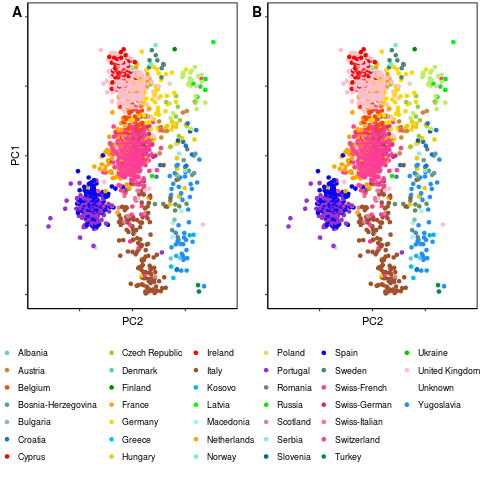

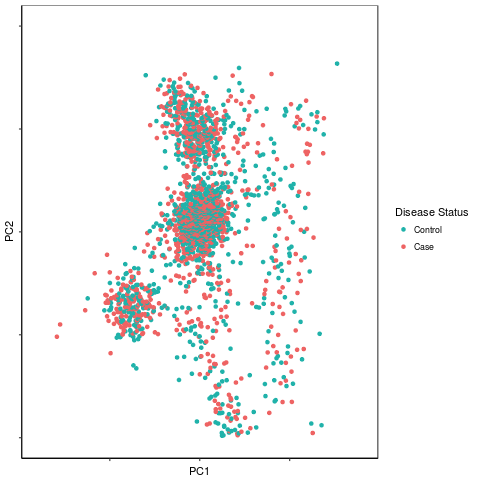

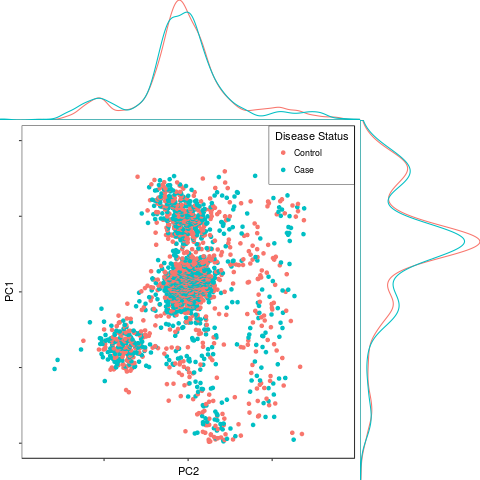

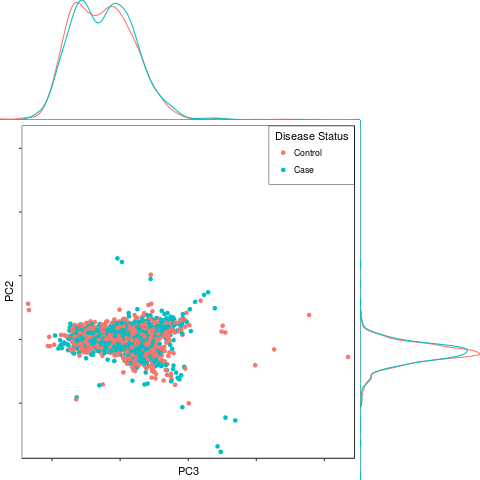

In [8]:
%%R -i colors -i cdf -i ddf 
library(repr)
options(repr.plot.width=7, repr.plot.height=7)
library(ggplot2)
library(cowplot)
library(gridExtra)


cmap = c()
for (i in 1:length(cdf$color)){
    cmap[toString(ddf$region[i])] = toString(ddf$color[i])
}
#margin = c(0,0,-1.5,.4)
xlims1 = 0.09   ; xlims2  = - 0.09
ylims1 = 0.05   ; ylims2 = -0.05

plt <- ggplot(cdf, aes(x=PC2, y=PC1)) + theme_bw()
plt <- plt +  geom_point(aes(colour = factor(cdf$region)))
plt <- plt + labs(x = "PC2", y = "PC1") 
plt <- plt + theme(legend.position="right", plot.margin = unit(c(.1,0,-3,.4), "cm"), 
                   legend.margin = margin(t = c(0,0,-3,0), unit='cm'))
plt <- plt + scale_colour_manual(values = cmap) + guides(color=guide_legend(title=element_blank(), ncol=6)) 
plt <- plt + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
plt <- plt  + ylim(ylims2, ylims1) + xlim(xlims2, xlims1)

plt2 <- ggplot(ddf, aes(x=PC2, y=PC1)) + theme_bw()
plt2 <- plt2 +  geom_point(aes(colour = factor(ddf$region)))
plt2 <- plt2 + labs(x = "PC2", y=element_blank()) 
plt2 <- plt2 + theme(legend.position="right", plot.margin = unit(c(.1,.1,-3,.4), "cm")) 
plt2 <- plt2 + scale_colour_manual(values = cmap) + guides(color=guide_legend(title=element_blank())) 
plt2 <- plt2 + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
plt2 <- plt2 + ylim(ylims2, ylims1) + xlim(xlims2, xlims1) 

prow <- plot_grid( plt + theme(legend.position="none"),
           plt2 + theme(legend.position="none"),
           align = 'vh',
           labels = c("A", "B"),
           hjust = -0.,
           nrow = 1,
           label_x=.05
           )

legend <- get_legend(plt + theme(legend.position="left")) 
p <- plot_grid( prow, legend, rel_widths = c(1, 1), scale = 1, ncol=1)

print(p)
ggsave('figures/PC1_PC2_sep.pdf', width=8, height= 6.5) #A4 size in inches

plt3 <- ggplot(ddf, aes(x=PC2, y=PC1)) + theme_bw()
plt3 <- plt3 +  geom_point(aes(colour = factor(ddf$status))) 
plt3 <- plt3 + labs(x = "PC1", y='PC2', color='Disease Status')
plt3 <- plt3 + scale_color_manual(labels = c("Control", "Case"), values = c("lightseagreen", "indianred2"))  
plt3 <- plt3 + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
plt3 <- plt3 + ylim(ylims2, ylims1) + xlim(xlims2, xlims1) 
# plt3 <- plt3 + geom_rug(data = subset(ddf, status == 1),
#              aes(x = PC1, y=PC2), inherit.aes = F)
print(plt3)

# ddf$bins <- cut(ddf$PC1,breaks = 20)
# p = ggplot(ddf, aes(x = bins, y = status)) + stat_summary(fun.y = "mean", geom = "point")
# p <- p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
#   panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
# print(p)

p1 <- ggplot(ddf, aes(x = PC2, y = PC1, colour=factor(status))) + geom_point() +   
  scale_x_continuous(expand=c(0.02,0)) +
  scale_y_continuous(expand=c(0.02,0)) +
  theme_bw() +
  labs("PC2", y='PC1', color='Disease Status') + 
  scale_color_hue(labels=c("Control", "Case")) + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
  panel.background = element_blank(), axis.line = element_blank(), axis.text=element_blank()) + 
  theme(legend.position = c(0.871, 0.911), legend.background = 
        element_rect(color = "black", size = .2, linetype = "solid")) +  ylim(ylims2, ylims1) + xlim(xlims2, xlims1) 


# # g_legend <-function(a.gplot){
# #   tmp = ggplot_gtable(ggplot_build(a.gplot))
# #   leg = which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
# #   legend = tmp$grobs[[leg]]
# #   return(legend)}
# # plegend<-g_legend(p1)


# # fit1.1 = approxfun(density(subset(ddf, status==1)$PC1))
# # fit0.1 = approxfun(density(subset(ddf, status==0)$PC1))
# # ddf$density1 = (fit1.1(ddf$PC1)/fit0.1(ddf$PC1))

# # fit1.2 = approxfun(density(subset(ddf, status==1)$PC2))
# # fit0.2 = approxfun(density(subset(ddf, status==0)$PC2))
# # ddf$density2 = (fit1.2(ddf$PC2)/fit0.2(ddf$PC2))

# # ddf$density = ddf$density/density(subset(ddf, status==0)$PC1)
# # print(ddf$density)

theme0 <- function(...) theme( legend.position = "none",
                               panel.background = element_blank(),
                               panel.grid.major = element_blank(),
                               panel.grid.minor = element_blank(),
                               panel.margin = unit(0,"null"),
                               axis.ticks = element_blank(),
                               axis.text.x = element_blank(),
                               axis.text.y = element_blank(),
                               axis.title.x = element_blank(),
                               axis.title.y = element_blank(),
                               axis.ticks.length = unit(0,"null"),
                               axis.ticks.margin = unit(0,"null"),
                               panel.border=element_rect(color=NA),...)
    
p2 <- ggplot(ddf,aes(x=PC1,colour=factor(status)))+#,fill=factor(status))) + 
  geom_density(alpha=0.5) +  
# p2 <- ggplot(ddf, aes(x = PC1, y=density1)) + #stat_summary(fun.y = "mean", geom = "point") + 
#   geom_line(alpha=0.5, color='black', size=1) +
  scale_x_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  scale_y_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  theme_bw() + coord_flip() + 
  theme0(plot.margin = unit(c(0,0,0,0),"lines")) 

p3 <- ggplot(ddf,aes(x=PC2,colour=factor(status))) + 
  geom_density(alpha=0.5) + 
# p3 <- ggplot(ddf, aes(x = PC1, y=density1)) + 
#   geom_line(alpha=0.5, color='black', size=1)  + 
  scale_x_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  scale_y_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  theme_bw() +
  theme0(plot.margin = unit(c(0,0,0,0),"lines"))
    
p = grid.arrange(arrangeGrob(p3,ncol=2,widths=c(3,1)),
             arrangeGrob(p1,p2,ncol=2,widths=c(3,1)),
             heights=c(1,3))
print(p)
ggsave('figures/casesVScontrols.pdf', plot=p, width=8, height= 6.5) #A4 size in inches
    
    
p1 <- ggplot(ddf, aes(x = PC3, y = PC4, colour=factor(status))) + geom_point() +   
  scale_x_continuous(expand=c(0.02,0)) +
  scale_y_continuous(expand=c(0.02,0)) +
  theme_bw() +
  labs("PC1", y='PC2', color='Disease Status') + 
  scale_color_hue(labels=c("Control", "Case")) + 
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
  panel.background = element_blank(), axis.line = element_blank(), axis.text=element_blank()) + 
  theme(legend.position = c(0.871, 0.911), legend.background = 
        element_rect(color = "black", size = .2, linetype = "solid")) 
    
p2 <- ggplot(ddf,aes(x=PC3,colour=factor(status)))+#,fill=factor(status))) + 
  geom_density(alpha=0.5) +  
# p2 <- ggplot(ddf, aes(x = PC1, y=density1)) + #stat_summary(fun.y = "mean", geom = "point") + 
#   geom_line(alpha=0.5, color='black', size=1) +
  scale_x_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  scale_y_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  theme_bw() +
  theme0(plot.margin = unit(c(0,0,0,0),"lines")) 

p3 <- ggplot(ddf,aes(x=PC4,colour=factor(status))) + 
  geom_density(alpha=0.5) + 
# p3 <- ggplot(ddf, aes(x = PC1, y=density1)) + 
#   geom_line(alpha=0.5, color='black', size=1) + 
  coord_flip()  + 
  scale_x_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  scale_y_continuous(labels = NULL,breaks=NULL,expand=c(0.001,0)) +
  theme_bw() +
  theme0(plot.margin = unit(c(0,0,0,0),"lines"))
    
p = grid.arrange(arrangeGrob(p2,ncol=2,widths=c(3,1)),
             arrangeGrob(p1,p3,ncol=2,widths=c(3,1)),
             heights=c(1,3))
print(p)
ggsave('figures/casesVScontrols3_4.pdf', plot=p, width=8, height= 6.5) #A4 size in inches

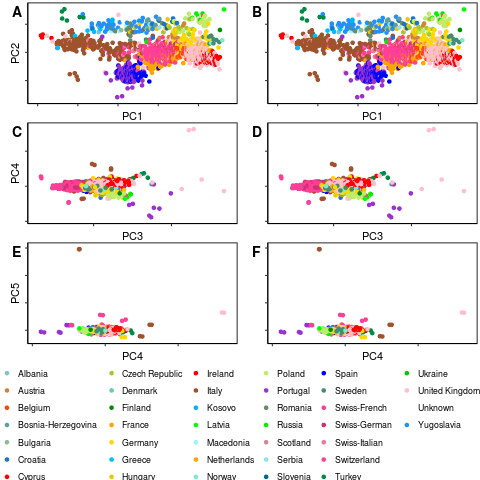

In [9]:
%%R -i colors -i cdf -i ddf 
library(repr)
options(repr.plot.width=7, repr.plot.height=7)
library(ggplot2)
library(cowplot)

cmap = c()
for (i in 1:length(cdf$color)){
    cmap[toString(ddf$region[i])] = toString(ddf$color[i])
}

plotter <- function(cdf, ddf, PC1, PC2) {
    x_upper = max(max(cdf[,PC1]), max(ddf[,PC1]))
    x_lower = min(min(cdf[,PC1]), max(ddf[,PC1]))
    gap = (x_upper - x_lower)/50
    x_upper = x_upper + gap 
    x_lower = x_lower - gap

    y_upper = max(max(cdf[,PC2]), max(ddf[,PC2]))
    y_lower = min(min(cdf[,PC2]), max(ddf[,PC2]))
    gap = (y_upper - y_lower)/50
    y_upper = y_upper + gap 
    y_lower = y_lower - gap
    
    plt12 <- ggplot(cdf, aes_string(x=PC1, y=PC2)) + theme_bw()
    plt12 <- plt12 +  geom_point(aes(colour = factor(cdf$region)))
    plt12 <- plt12 + labs(x = PC1, y = PC2) 
    plt12 <- plt12 + theme(legend.position="right", plot.margin = unit(c(.1,.1,0,.4), "cm"), 
                   legend.margin = margin(t = c(0,0,-.2,0), unit='cm'))
    plt12 <- plt12 + scale_colour_manual(values = cmap) + guides(color=guide_legend(title=element_blank(), ncol=6)) 
    plt12 <- plt12 + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
    plt12 <- plt12 + xlim(x_lower, x_upper) + ylim(y_lower, y_upper)

    dplt12 <- ggplot(ddf, aes_string(x=PC1, y=PC2)) + theme_bw()
    dplt12 <- dplt12 +  geom_point(aes(colour = factor(ddf$region)))
    dplt12 <- dplt12 + labs(x = PC1, y=element_blank())  
    dplt12 <- dplt12 + theme(legend.position="right", plot.margin = unit(c(.1,.1,0,.4), "cm")) 
    dplt12 <- dplt12 + scale_colour_manual(values = cmap) + guides(color=guide_legend(title=element_blank())) 
    dplt12 <- dplt12 + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
    panel.background = element_blank(), axis.line = element_line(colour = "black"), axis.text=element_blank())
    dplt12 <- dplt12 + xlim(x_lower, x_upper) + ylim(y_lower, y_upper)
    return(list("plt" = plt12, "dplt" = dplt12))
}

plt <- plotter(cdf, ddf, "PC1", "PC2")
plt12 = plt$plt
dplt12 = plt$dplt

plt <- plotter(cdf, ddf, "PC3", "PC4")
plt34 = plt$plt
dplt34 = plt$dplt

plt <- plotter(cdf, ddf, "PC4", "PC5")
plt45 = plt$plt
dplt45 = plt$dplt


prow <- plot_grid( plt12 + theme(legend.position="none"),
                  dplt12 + theme(legend.position="none"),
                  plt34 + theme(legend.position="none"),
                  dplt34 + theme(legend.position="none"),
                  plt45 + theme(legend.position="none"),
                  dplt45 + theme(legend.position="none"),
           align = 'vh',
           labels = "AUTO",
           hjust = -0.,
           nrow = 3,
           label_x=.05
           )

legend <- get_legend(plt12 + theme(legend.position="left")) 
p <- plot_grid( prow, legend, rel_heights = c(3, 1), scale = 1, ncol=1)

print(p)
ggsave('figures/PCs_sep.pdf', width=8, height= 7)


# Manhattan Plots

In [10]:
def manhattan(data, chrom, pval = "pCoef",ax=None, plot_type='scatter', alpha=.7, line=True, **kwargs):
    sns.set(font_scale=1)
    sns.set_style("white")
    sns.despine(left=True)
    colors = sns.color_palette("hls", 8)[5:7]
    y = -np.log10(data[pval] + _EPS)
    x = np.array(range(len(data.coef)))
    c = np.array([colors[int(i)%2] for i in data.chrom])
    
    edge_clearance = 1000
    
    if ax is None: 
        fig, ax = plt.subplots(figsize=(12,6))
    
    if plot_type == 'scatter':
        ax.scatter(x, y, c=c, alpha=alpha, edgecolors='none', **kwargs)

    if line:
        ax.axhline(-np.log10(.01/len(y)), color='.5', linestyle='--')

#     if xtick_label_set is None: 
#     xtick_label_set = set(xs_by_id.keys())
    ax.set_xlim(-edge_clearance, len(x)+edge_clearance)
    ax.set_ylim(ymin=np.nanmin(y))
    
#    ax.set_xlabel("chromosome 1") 
    
    chroms, count = np.unique(data.chrom, return_counts=True)
    # Find the center point to place the label
    tick_pos = []
    i = 0
    for c, n in zip(chroms, count):
        tick_pos.append(i + n/2)
        i += n
    
    # last tick tends to have too little room 
    tick_pos[-1] += edge_clearance
    
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(labels=sorted(chroms.astype(int)))
    ax.set_ylabel(r'$-\log_{10}($P$)$',fontsize=16)
    sns.despine(fig=None, ax=ax, top=True, right=True, left=True, bottom=True, offset=None, trim=False)


    return fig, ax


In [11]:
headerNames = ["coef", "PC1", "PC2", "PC3", "PC4", "PC5", "pCoef",
               "pPC1", "pPC2", "pPC3","pPC4","pPC5", "pll", "chrom"]
data = pd.read_table("cleanedData/centralized.txtbetas.txt", header=None, names=headerNames)
#data = data.drop(data.index[len(data)-1])  # I'm currently accidentally writing an extra snp after the loop is exited 
data['pll'] = chi2.sf(-2*data.pll, 1)
AF = pd.read_table('cleanedData/geno05maf05.frq', sep=r"\s*")
AF.head()

/home/apoursh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


,CHR,SNP,A1,A2,MAF,NCHROBS
0,1,rs3094315,G,A,0.16640,4382
1,1,rs4075116,C,T,0.27460,4526
2,1,rs9442385,T,G,0.07237,4408
3,1,rs10907175,C,A,0.07955,4538
4,1,rs2887286,C,T,0.16130,4414


<Figure size 1200x1200 with 0 Axes>

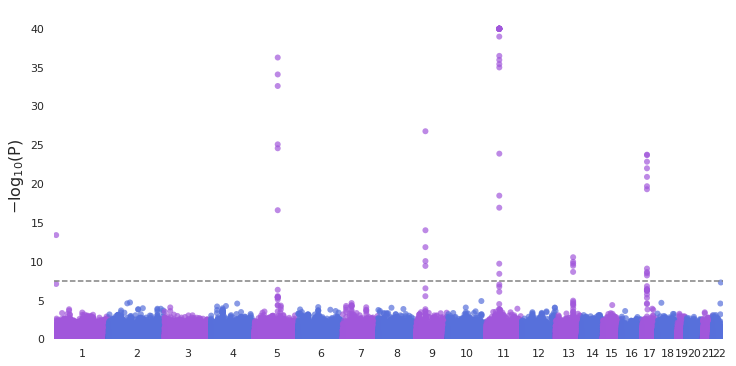

In [12]:
fig, ax = manhattan(data, chrom=None, pval="pll")
fig.savefig("figures/Centralized_CC_pll.pdf", bbox_inches='tight')

<Figure size 1200x1200 with 0 Axes>

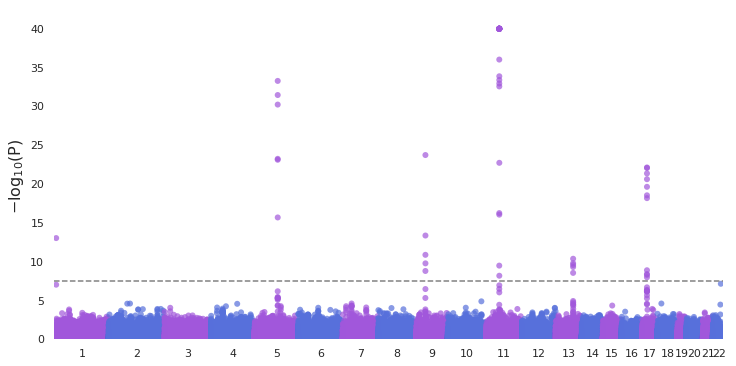

In [13]:
fig, ax = manhattan(data, chrom=None)
fig.savefig("figures/Centralized_CC_wald.pdf", bbox_inches='tight')

## But, which one is more powerful 

In [14]:
def corr_plot(data1, data2, var, xlab, ylab, var2=None, chrom=None, ax=None, plot_type='scatter', alpha=.7, **kwargs):
    sns.set_style("white")
    sns.despine(left=True)
    #colors = sns.color_palette("hls", 8)[5:7]
    if var2 is None:
        var2 = var
    if chrom is not None:
        x = data1[data1.chrom==chrom][var]
        y = data2[data2.chrom==chrom][var2]
    else: 
        x = data1[var]
        y = data2[var2]
#     edge_clearance = 1000
    if var.startswith('p'):
#         x.loc[x<_EPS] = _EPS
#         y.loc[y<_EPS] = _EPS
        tmp = x
        x = x[tmp>_EPS] 
        y = y[tmp>_EPS]
        del tmp
        x = -np.log10(x)
        y = -np.log10(y)
    
    if ax is None: 
        ax = plt.gca()
    
    if plot_type == 'scatter':
        ax.scatter(x, y, alpha=alpha, edgecolors='none',
                   **kwargs)
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        lims = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
        line = np.linspace(lims[0], lims[1])
        ax.plot(line, line, color="r", ls="--", alpha=alpha/2)
        textx = lims[1]*.4 + lims[0] * .6
        texty = lims[1]*.93 + lims[0]*.07
        ax.text(textx,texty ,'$R^2$={:.6}'.format(np.corrcoef(x,y)[0,1]**2), fontsize=28)
        ax.set(ylim=lims, xlim=lims)
        
        ax.set(xlabel=xlab, ylabel=ylab)

        
    return ax


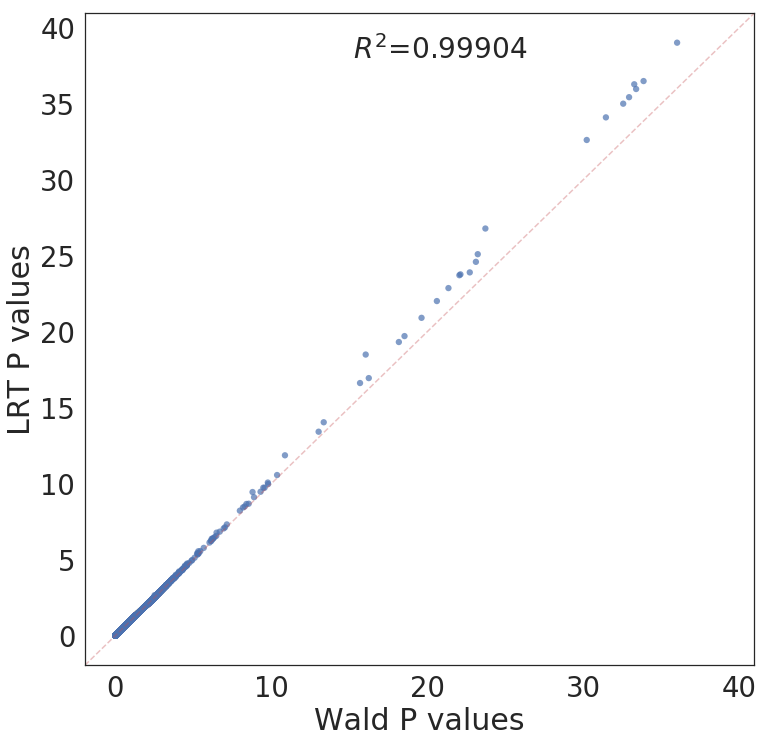

In [15]:
sns.set(font_scale=2.5)
ax = corr_plot(data, data, var='pCoef', var2='pll', xlab="Wald P values", ylab="LRT P values",
               chrom=None, ax=None, plot_type='scatter', alpha=.7, s=40)
fig = plt.gcf()
fig.savefig("figures/wald_vs_LRT.pdf", bbox_inches='tight')

In [16]:
headerNames = ["coef0", "coef1", "coef2", "coef3", "coef4", "se0", "se1", "se2", 
               "se3", "se4", "pPC0","pPC1","pPC2","pPC3","pPC4", "chrom"]


mdata = pd.read_table('cleanedData/meta_five_betas.txt', header=None, names=headerNames, sep=" ")
mdata.chrom = pd.to_numeric(mdata.chrom)
mdata['colFromIndex'] = mdata.index
mdata = mdata.sort_values(by=['chrom', 'colFromIndex']) # need to keep order of the rest unchanged
mdata = mdata.reset_index()
mdata = mdata.drop("index", axis=1)
mdata["totVar"] = 1/mdata.se0**2 + 1/mdata.se1**2 + 1/mdata.se2**2+ 1/mdata.se3**2+ 1/mdata.se4**2#(mdata.iloc[:, :5]**2).sum(axis=1)
mdata['FE'] = (mdata.coef0 * 1/mdata.se0**2 + mdata.coef1 * 1/mdata.se1**2 + mdata.coef2 * 1/mdata.se2**2 + 
  mdata.coef3 * 1/mdata.se3**2 + mdata.coef4 * 1/mdata.se4**2).div(mdata.totVar)
mdata['pVals'] = norm.sf(abs(mdata.FE * mdata.totVar.apply(np.sqrt)))*2

In [17]:
headerNames = ["coef", "PC1", "PC2", "PC3", "PC4", "PC5", "pCoef",
               "pPC1", "pPC2", "pPC3","pPC4","pPC5", "pll", "chrom"]
fdata = pd.read_table("cleanedData/uniformSplit/five_way/five_D_betas.txt", header=None, names=headerNames)
fdata['pll'] = chi2.sf(-2*fdata.pll, 1)
fdata.chrom = pd.to_numeric(fdata.chrom)
fdata['colFromIndex'] = fdata.index
fdata = fdata.sort_values(by=['chrom', 'colFromIndex']) # need to keep order of the rest unchanged
fdata = fdata.reset_index()
fdata = fdata.drop(["index", "colFromIndex"], axis=1)

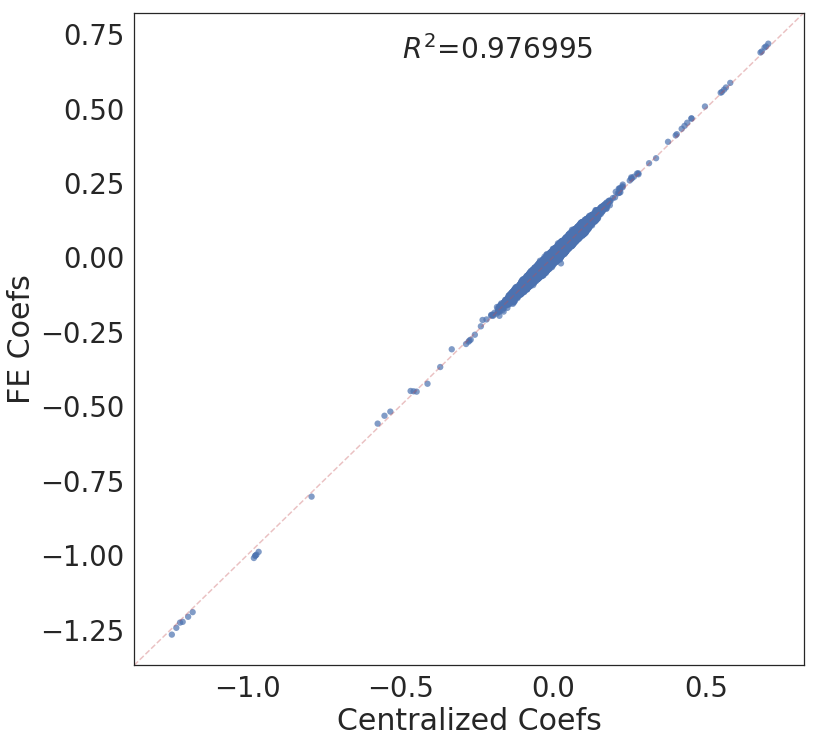

In [18]:
sns.set(font_scale=2.5)
ax = corr_plot(data, mdata, var='coef', var2='FE', xlab="Centralized Coefs", ylab="FE Coefs",
               chrom=None,  ax=None, plot_type='scatter', alpha=.7, s=40)
fig = plt.gcf()
fig.savefig("figures/FE_coef.pdf", bbox_inches='tight')

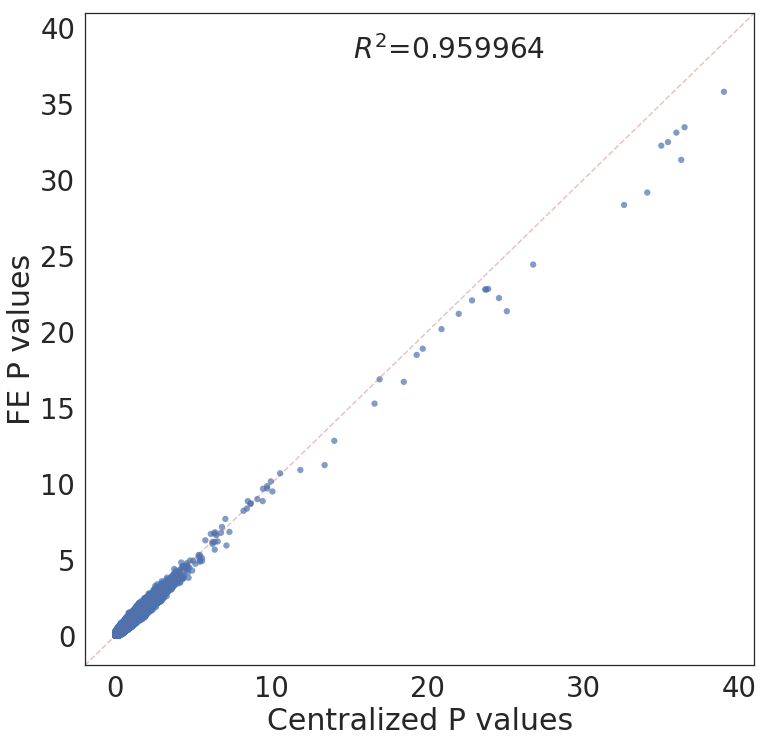

In [19]:
sns.set(font_scale=2.5)
ax = corr_plot(data, mdata, var='pll', var2='pVals', xlab="Centralized P values", ylab="FE P values",
               chrom=None,  ax=None, plot_type='scatter', alpha=.7, s=40)
fig = plt.gcf()
fig.savefig("figures/FE_pvals.pdf", bbox_inches='tight')

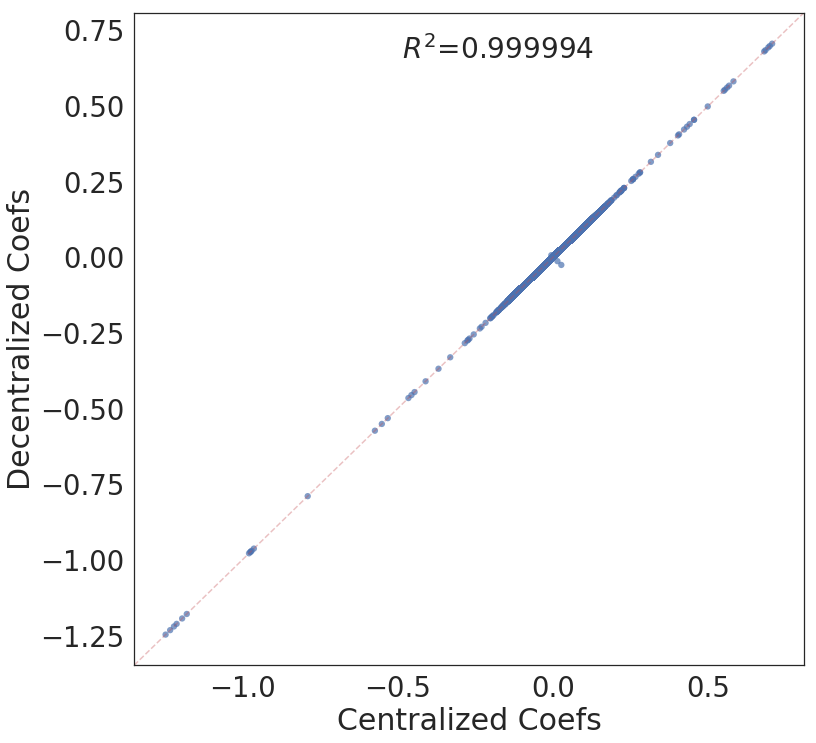

In [20]:
sns.set(font_scale=2.5)
ax = corr_plot(data, fdata, var='coef', var2='coef', xlab="Centralized Coefs", ylab="Decentralized Coefs",
               chrom=None, ax=None, plot_type='scatter', alpha=.7, s=40)
fig = plt.gcf()
fig.savefig("figures/five_coef.pdf", bbox_inches='tight')

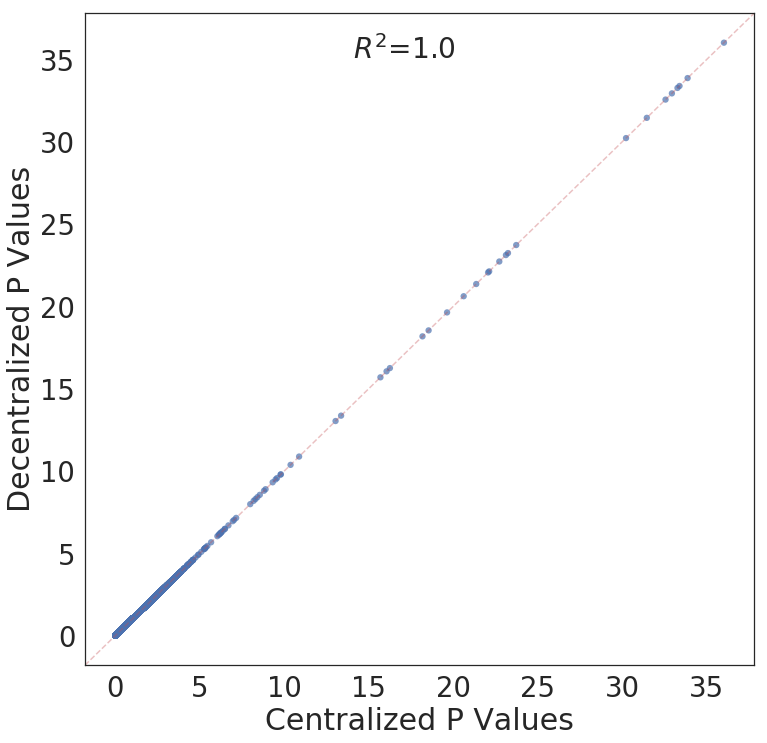

In [21]:
sns.set(font_scale=2.5)
ax = corr_plot(data, fdata, var='pCoef', var2='pCoef', xlab="Centralized P Values", ylab="Decentralized P Values",
               chrom=None, ax=None, plot_type='scatter', alpha=.7, s=40)
fig = plt.gcf()
fig.savefig("figures/five_Waldp.pdf", bbox_inches='tight')

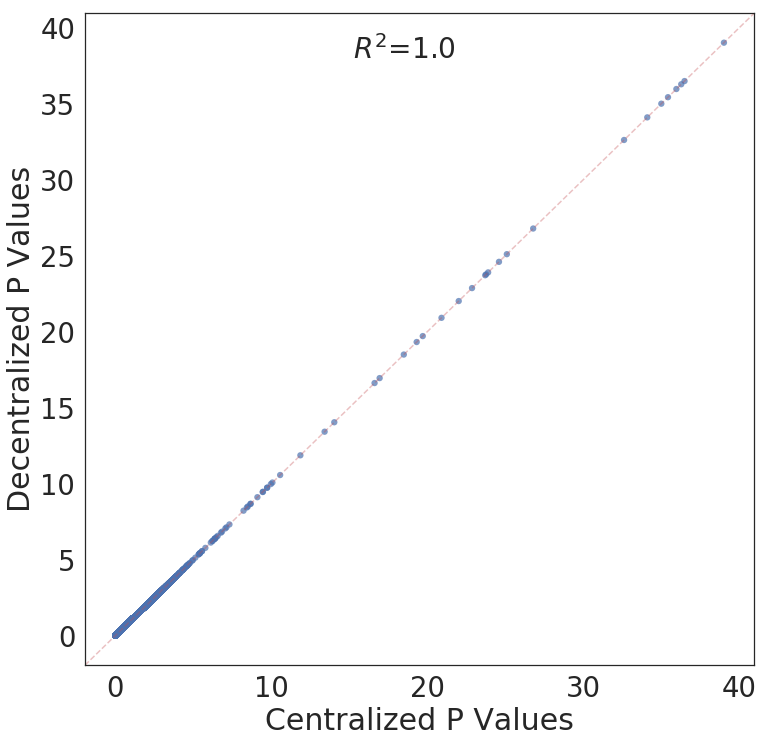

In [22]:
sns.set(font_scale=2.5)
ax = corr_plot(data, fdata, var='pll', var2='pll', xlab="Centralized P Values", ylab="Decentralized P Values",
               chrom=None, ax=None, plot_type='scatter', alpha=.7, s=40)
fig = plt.gcf()
fig.savefig("figures/five_LRTp.pdf", bbox_inches='tight')

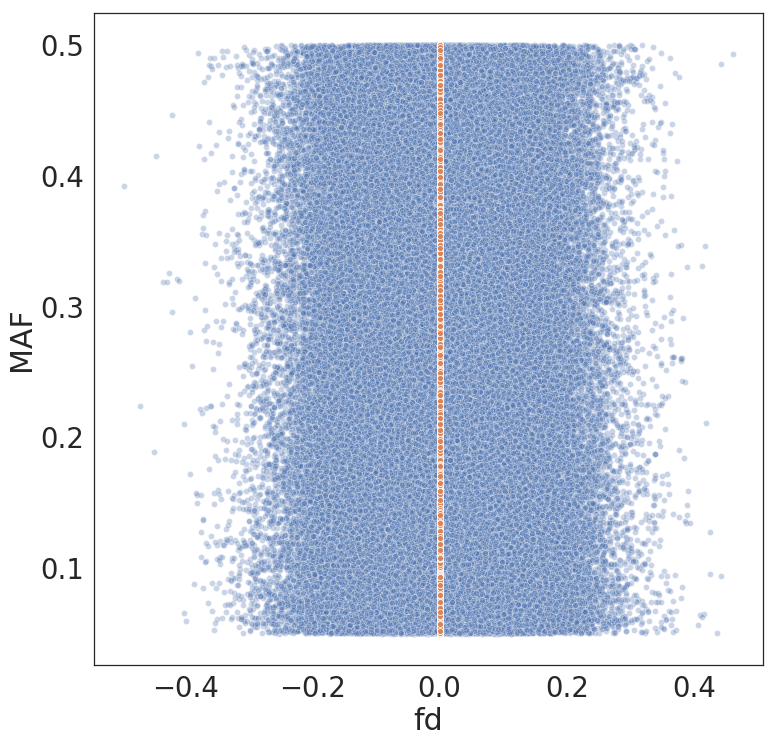

In [23]:
df = pd.DataFrame({})
df['md'] = mdata.pVals - data.pll
df['fd'] = fdata.pll - data.pll
df["MAF"] = AF.MAF
 
ax = sns.scatterplot(data = df, x='md', y = 'MAF', alpha=.3)
sns.scatterplot(data=df, x='fd', y = 'MAF', ax=ax)

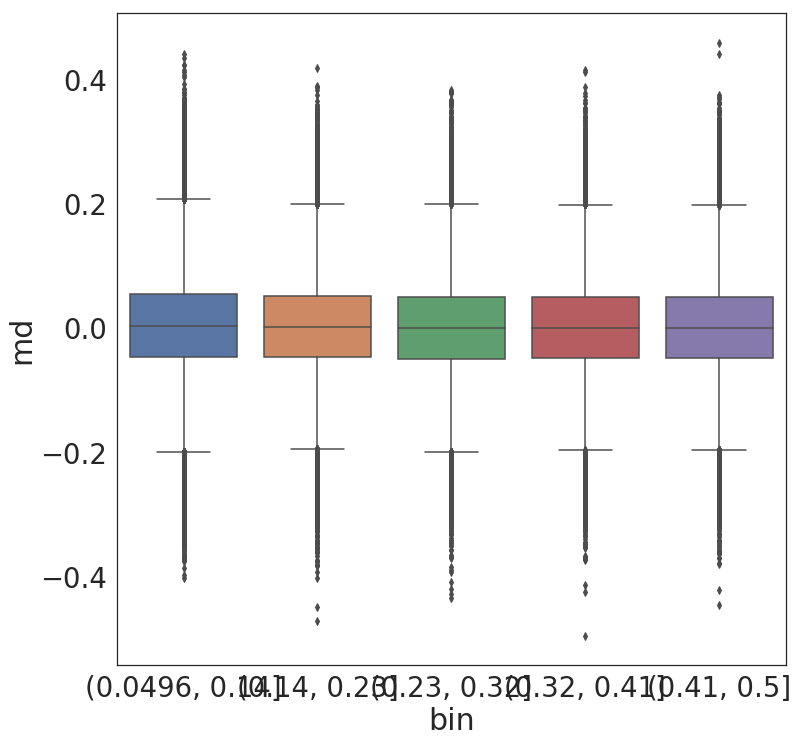

In [24]:
df['bin']  = pd.cut(df.MAF, 5)
sns.boxplot(data=df, y='md', x='bin')

Oddly, no effect from MAF on the spread but fairly vide variance throughout. 

In [25]:
chrom = 17
timeSeries = pd.read_table('cleanedData/five_D_betas_iters.txt', sep=r"\t", header=None, names=["coef", "PC1", "PC2", "PC3", "PC4", "PC5", "pCoef",
               "pPC1", "pPC2", "pPC3","pPC4","pPC5", "deltaell", "chrom", "iter"], usecols=["coef", "pCoef", "iter", "deltaell"])
niters = 101
timeSeries["snp"] = np.array([np.repeat(i, niters) for i in range(timeSeries.shape[0]/niters)]).flatten()
timeSeries["pll"] = chi2.sf(-2*timeSeries.deltaell, 1)

dummydata = data[data.chrom==chrom].copy()
dummydata["snp"] = range(dummydata.shape[0])
dummydata = dummydata.loc[:, ["coef", "snp", "pll"]]
dummydata["AF"] = AF.MAF[AF.CHR==chrom]

new = timeSeries.merge(dummydata,on=['snp'],how='left')
tmp = pd.DataFrame()
tmp["FE"] = mdata.FE[mdata.chrom == chrom]
tmp["mPvals"] = mdata.pVals[mdata.chrom == chrom]
tmp["snp"] = range(tmp.shape[0])
new = new.merge(tmp,on=['snp'],how='left')


timeSeries["Iterative"] = np.log10(np.abs(new.coef_x - new.coef_y))
timeSeries["Meta-study"] = np.log10(np.abs(new.FE - new.coef_y))
timeSeries["Ccoef"] = new.coef_y

timeSeries["Iterative P"] = np.log((np.abs(new.pll_x - new.pll_y))/(new.pll_y+_EPS))
timeSeries["Meta-study P"] = np.log(np.abs(new.mPvals - new.pll_y)/(new.pll_y+_EPS))

timeSeries["AF"] = new["AF"]
timeSeries["mPvals"] = new.mPvals
del new, dummydata, tmp

tmpdf = data[data.chrom == chrom].reset_index()
sigIndex = tmpdf[tmpdf.pll < .01/data.shape[0]].index.tolist()
del tmpdf

timeSeries['Status'] = ["Significant" if i.snp in sigIndex else "Non-significant" for _,i in timeSeries.iterrows()]


/home/apoursh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


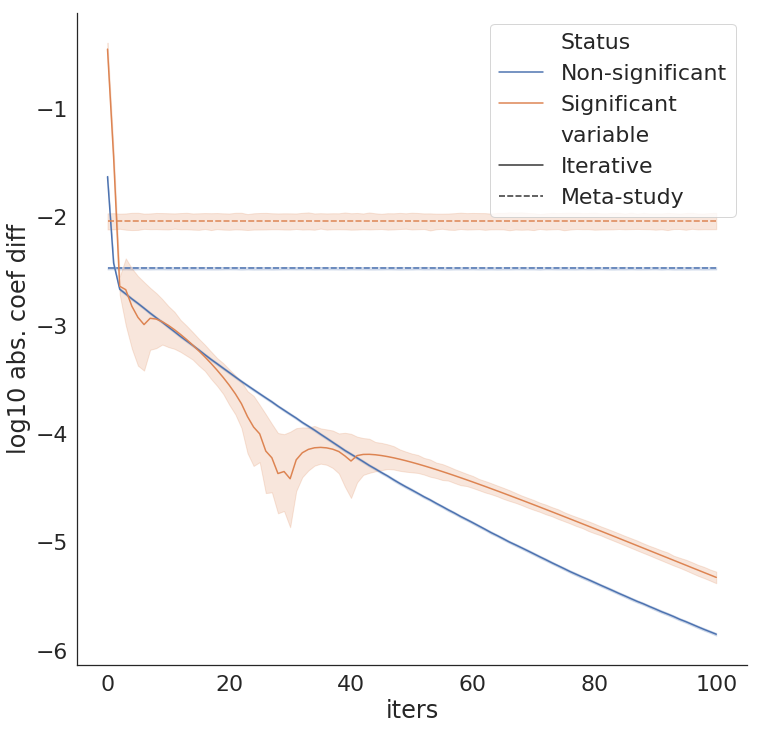

In [26]:
df = pd.melt(timeSeries, id_vars=list(set(timeSeries.columns)-set(["Iterative", "Meta-study"])))
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.lineplot(data=df, y='value', x='iter', hue="Status", style="variable")
sns.despine()
ax.set(ylabel="log10 abs. coef diff", xlabel="iters")
ax.figure.savefig("figures/five_iters.pdf")

In [27]:
palette = [sns.color_palette("deep", 7)[1]]

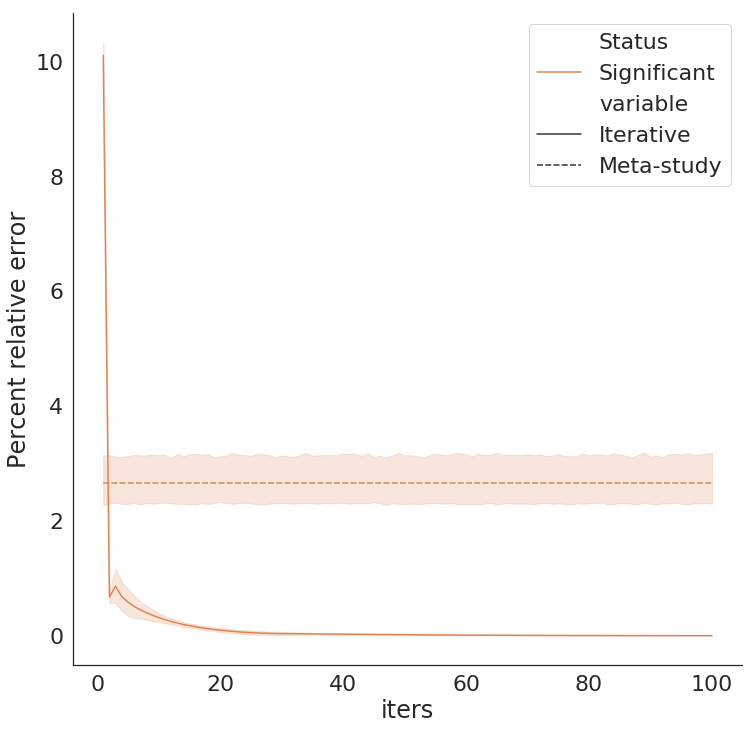

In [28]:
sns.set(font_scale=2)
sns.set_style("white")
rdf = df[np.logical_and(df.iter>0, df.Status=="Significant")]
ax = sns.lineplot(data=rdf, y=pow(10,rdf.value)*100/rdf.Ccoef, x='iter', hue="Status", style="variable", palette=palette)
sns.despine()
ax.set(ylabel="Percent relative error", xlabel="iters")
ax.figure.savefig("figures/five_iters_rel.pdf")

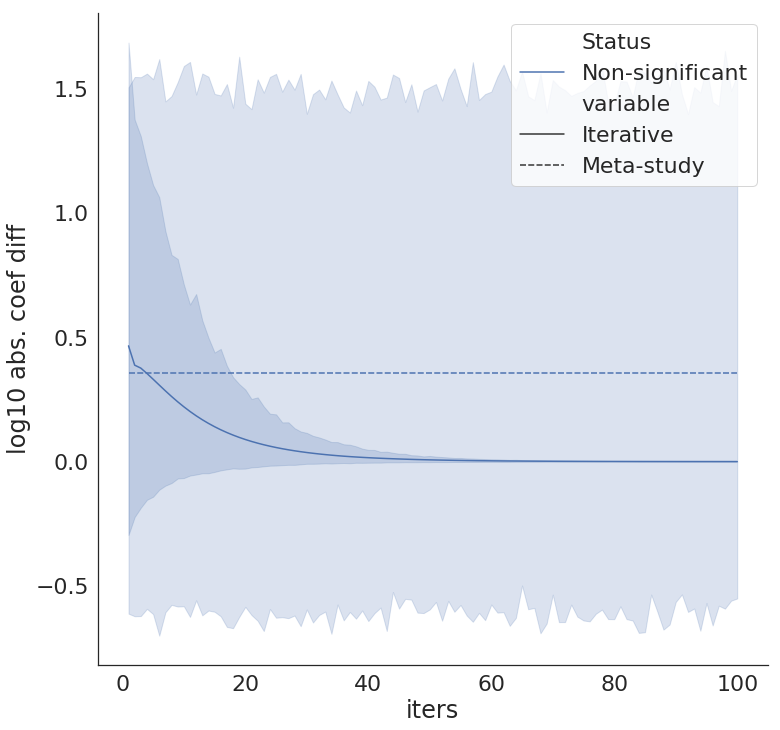

In [29]:
sns.set(font_scale=2)
sns.set_style("white")

rdf = df[np.logical_and(df.iter>0, df.Status=="Non-significant")]
ax = sns.lineplot(data=rdf, y=pow(10,rdf.value)/rdf.Ccoef, x='iter', hue="Status", style="variable")
sns.despine()
ax.set(ylabel="log10 abs. coef diff", xlabel="iters")
ax.figure.savefig("figures/five_iters_rel.pdf")

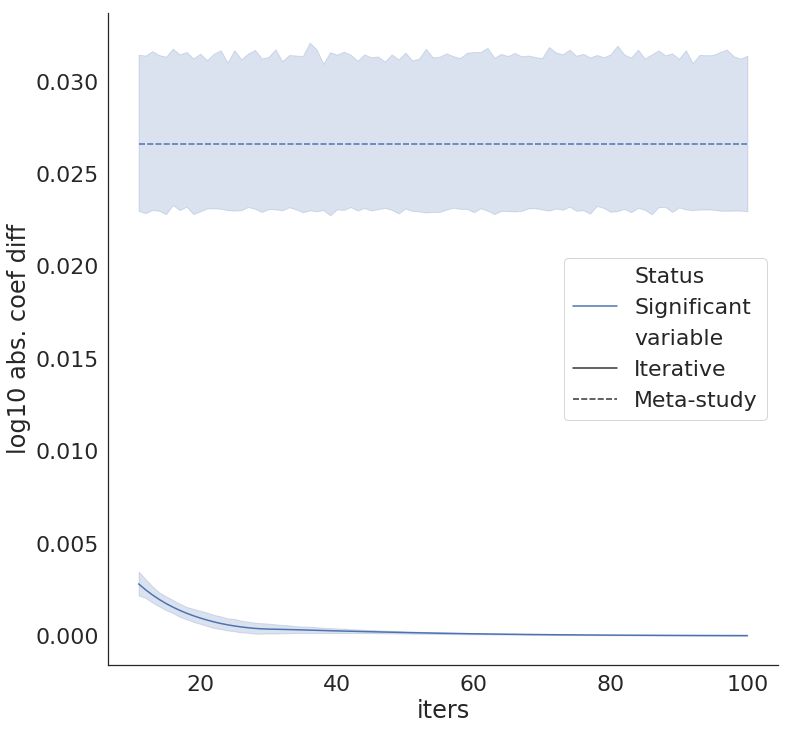

In [30]:
sns.set(font_scale=2)
sns.set_style("white")

rdf = df[np.logical_and(df.iter>10, df.Status=="Significant")]
ax = sns.lineplot(data=rdf, y=pow(10,rdf.value)/rdf.Ccoef, x='iter', hue="Status", style="variable")
sns.despine()
ax.set(ylabel="log10 abs. coef diff", xlabel="iters")
ax.figure.savefig("figures/five_iters_rel.pdf")

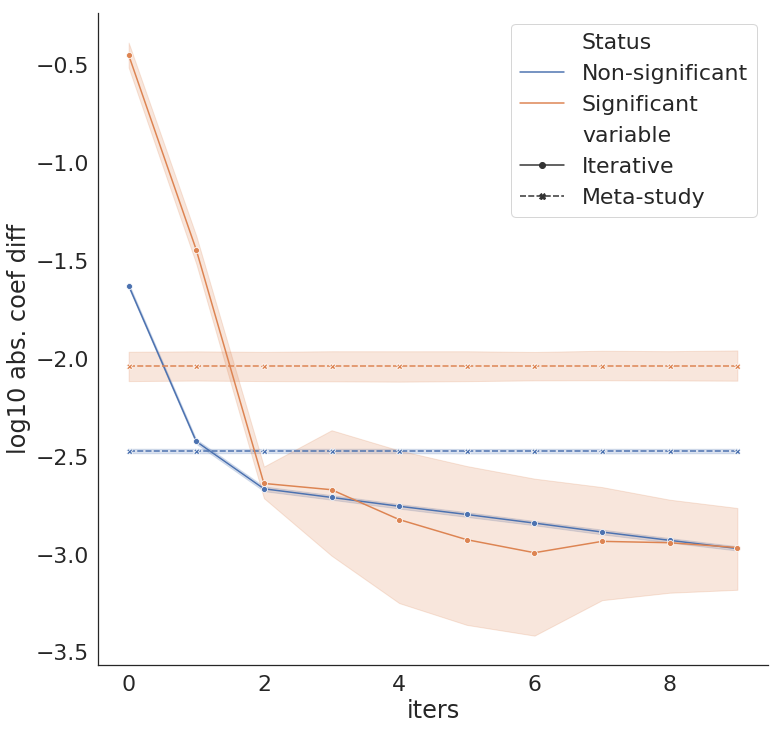

In [32]:
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.lineplot(data=df[df.iter<10], y='value', x='iter', hue="Status", style="variable", markers=True)
sns.despine()
ax.set(ylabel="log10 abs. coef diff", xlabel="iters")
ax.figure.savefig("figures/five_few_iters.pdf")

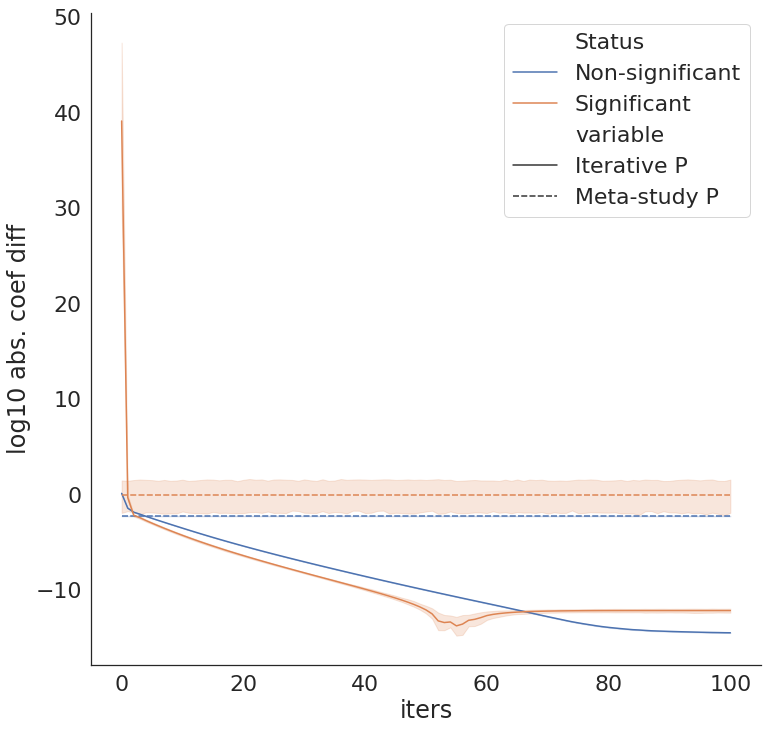

In [33]:
df = pd.melt(timeSeries, id_vars=list(set(timeSeries.columns)-set(["Iterative P", "Meta-study P"])))
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.lineplot(data=df, y='value', x='iter', hue="Status", style="variable")
sns.despine()
ax.set(ylabel="log10 abs. coef diff", xlabel="iters")
ax.figure.savefig("figures/five_iters_pvals.pdf")

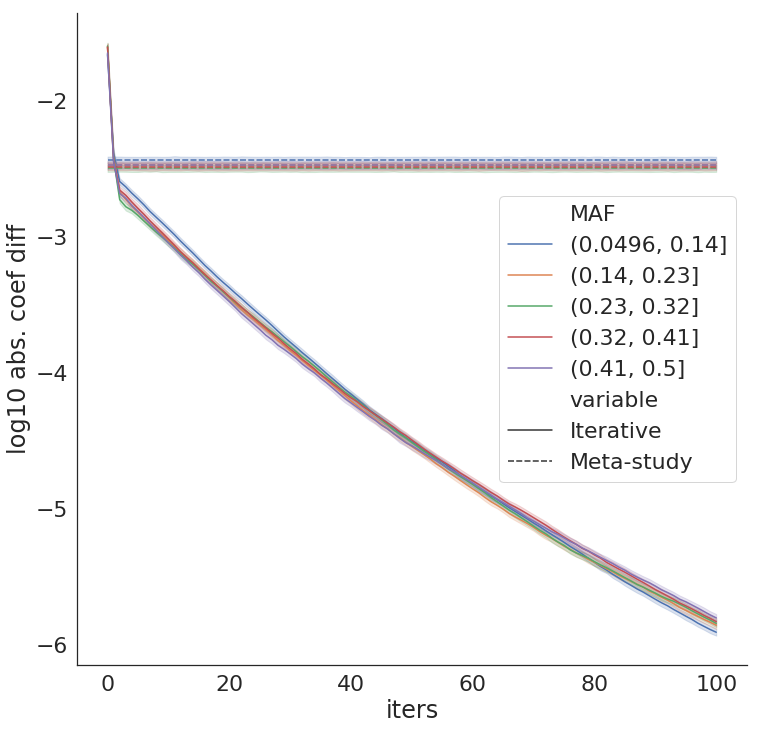

In [34]:
df = pd.melt(timeSeries, id_vars=list(set(timeSeries.columns)-set(["Iterative", "Meta-study"])))
df['MAF'] = pd.cut(df.AF, 5)
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.lineplot(data=df, y='value', x='iter', hue="MAF", style="variable")
sns.despine()
ax.set(ylabel="log10 abs. coef diff", xlabel="iters")
ax.figure.savefig("figures/five_iters_MAF.pdf")

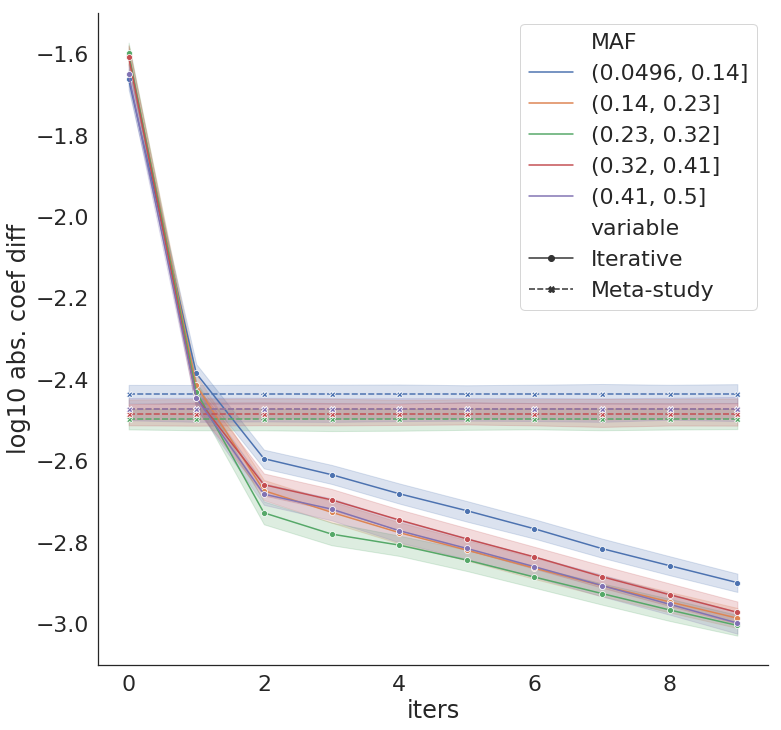

In [35]:
df = pd.melt(timeSeries, id_vars=list(set(timeSeries.columns)-set(["Iterative", "Meta-study"])))
df['MAF'] = pd.cut(df.AF, 5)
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.lineplot(data=df[df.iter<10], y='value', x='iter', hue="MAF", style="variable", markers=True)
sns.despine()
ax.set(ylabel="log10 abs. coef diff", xlabel="iters")
ax.figure.savefig("figures/five_few_iters_MAF.pdf")

## Scenario 2 

In [36]:
headerNames = ["coef", "PC1", "PC2", "PC3", "PC4", "PC5", "pCoef",
               "pPC1", "pPC2", "pPC3","pPC4","pPC5", "pll", "chrom"]
ddata = pd.read_table("cleanedData/CC_D_betas.txt", header=None, names=headerNames)
# ddata = ddata.drop(ddata.index[len(ddata)-1])  # I'm currently accidentally writing an extra snp after the loop is exited 
ddata['pll'] = chi2.sf(-2*ddata.pll, 1)
ddata.chrom = pd.to_numeric(ddata.chrom)
ddata['colFromIndex'] = ddata.index
ddata = ddata.sort_values(by=['chrom', 'colFromIndex']) # need to keep order of the rest unchanged
ddata = ddata.reset_index()
ddata = ddata.drop(["index", "colFromIndex"], axis=1)

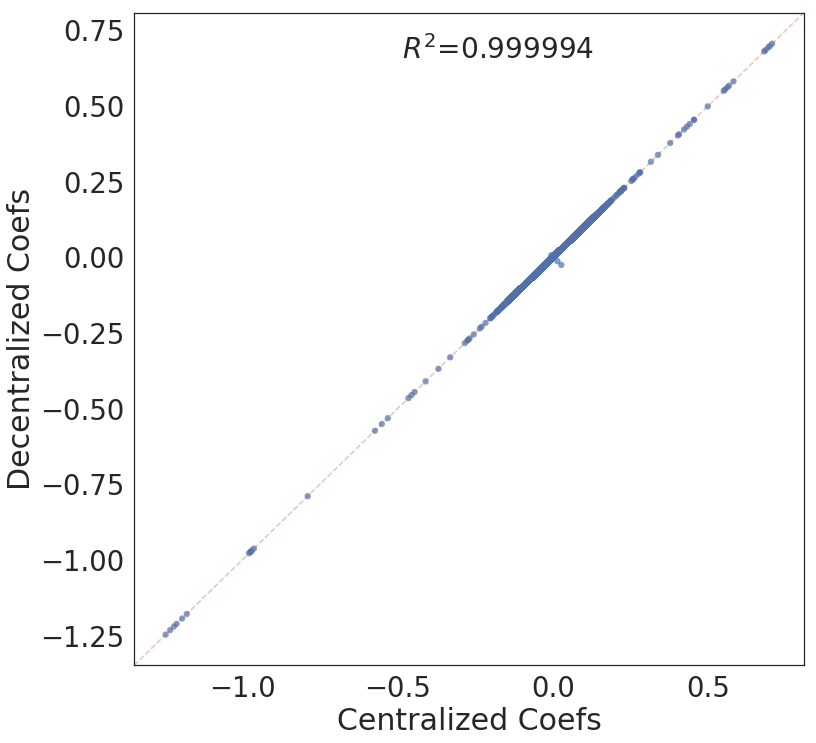

In [37]:
sns.set(font_scale=2.5)
ax = corr_plot(data, ddata, var='coef', var2='coef', xlab="Centralized Coefs", ylab="Decentralized Coefs",
               chrom=None, ax=None, plot_type='scatter', alpha=.7, s=40)
fig = plt.gcf()
fig.savefig("figures/sep_coef.pdf", bbox_inches='tight')

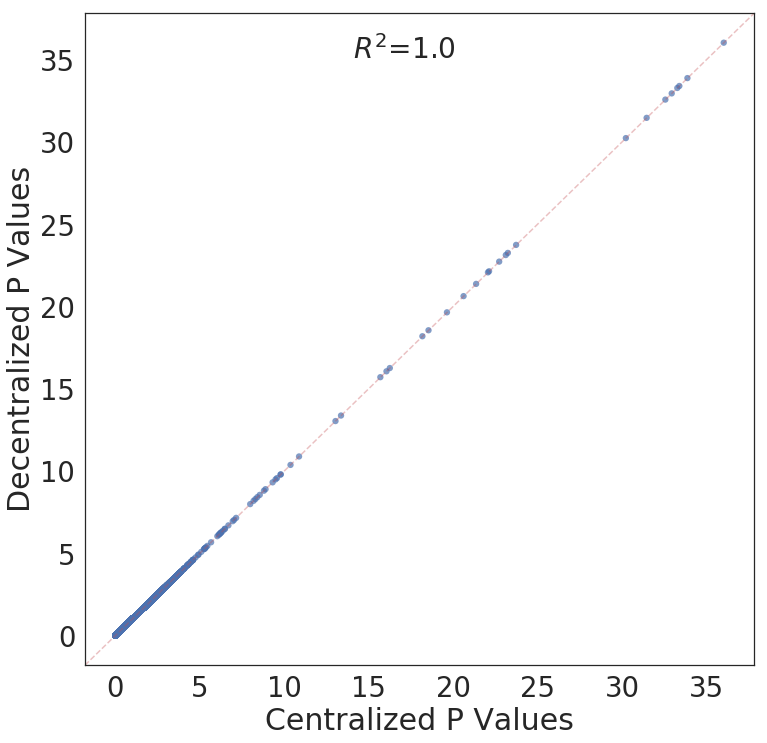

In [38]:
sns.set(font_scale=2.5)
ax = corr_plot(data, ddata, var='pCoef', var2='pCoef', xlab="Centralized P Values", ylab="Decentralized P Values",
               chrom=None, ax=None, plot_type='scatter', alpha=.7, s=40)
fig = plt.gcf()
fig.savefig("figures/sep_Waldp.pdf", bbox_inches='tight')

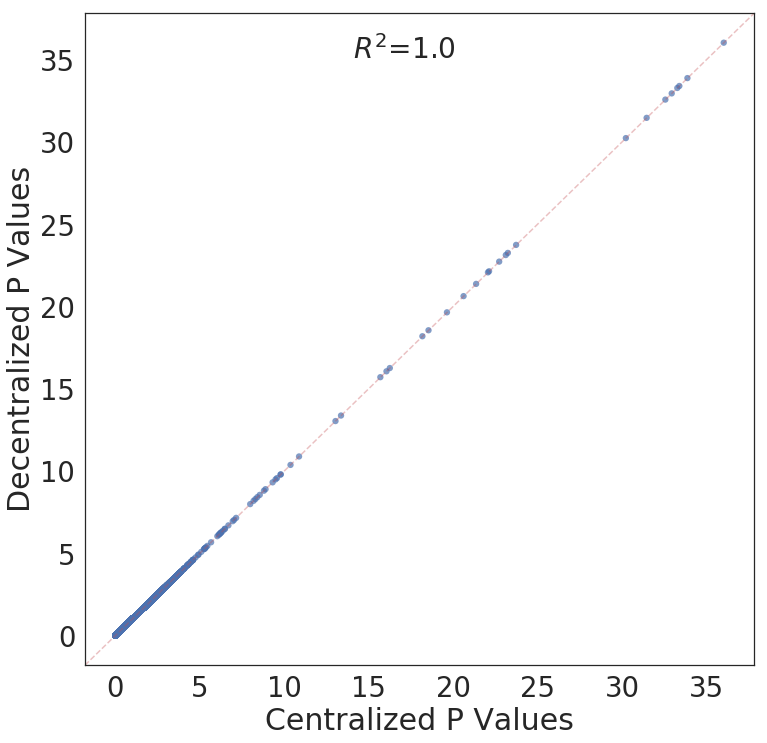

In [39]:
sns.set(font_scale=2.5)
ax = corr_plot(data, ddata, var='pCoef', var2='pCoef', xlab="Centralized P Values", ylab="Decentralized P Values",
               chrom=None, ax=None, plot_type='scatter', alpha=.7, s=40)
fig = plt.gcf()
fig.savefig("figures/sep_LRTp.pdf", bbox_inches='tight')

In [40]:
chrom = 17
timeSeries = pd.read_table('cleanedData/CC_17_betas_iters.txt', sep=r"\t", header=None, names=["coef", "PC1", "PC2", "PC3", "PC4", "PC5", "pCoef",
               "pPC1", "pPC2", "pPC3","pPC4","pPC5", "deltaell", "chrom", "iter"], usecols=["coef", "pCoef", "iter", "deltaell"])
niters = 101
timeSeries["snp"] = np.array([np.repeat(i, niters) for i in range(timeSeries.shape[0]/niters)]).flatten()

dummydata = data[data.chrom==chrom].copy()
dummydata["snp"] = range(dummydata.shape[0])
dummydata = dummydata.loc[:, ["coef", "snp"]]
dummydata["AF"] = AF.MAF[AF.CHR==chrom]

new = timeSeries.merge(dummydata,on=['snp'],how='left')
timeSeries.coef = np.log10(np.abs(new.coef_x - new.coef_y))
timeSeries["Ccoef"] = new.coef_y
timeSeries["AF"] = new["AF"]
del new, dummydata

tmpdf = data[data.chrom == chrom].reset_index()
sigIndex = tmpdf[tmpdf.pll < .01/data.shape[0]].index.tolist()
del tmpdf

timeSeries['Status'] = ["Significant" if i.snp in sigIndex else "Non-significant" for _,i in timeSeries.iterrows()]


/home/apoursh/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


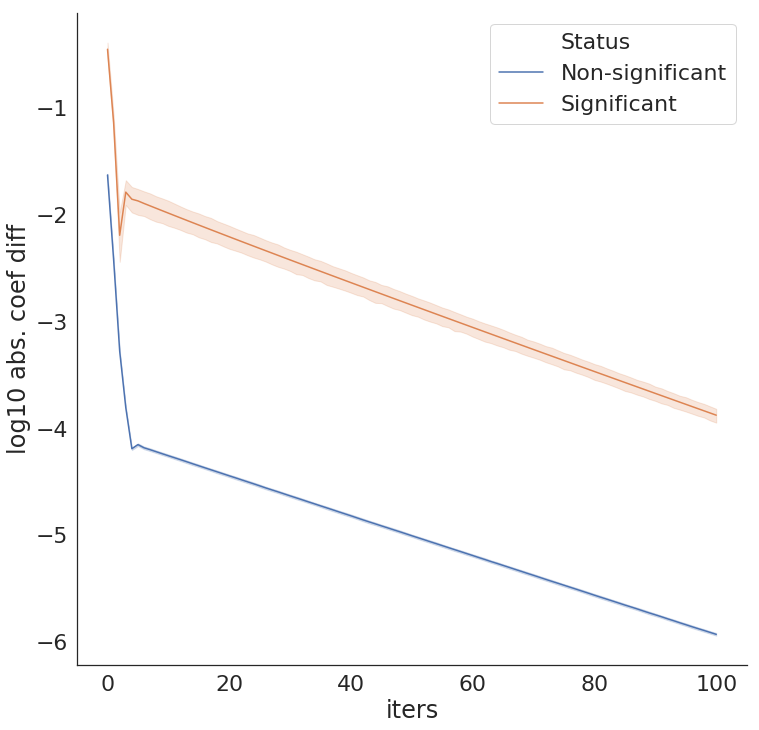

In [41]:
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.lineplot(data=timeSeries, y='coef', x='iter', hue="Status")
# ax = sns.lineplot(data=timeSeries, y='mcoef', x='iter', hue="condition", ax=ax,linestyle='--')
sns.despine()
ax.set(ylabel="log10 abs. coef diff", xlabel="iters")
ax.figure.savefig("figures/CC_iters_CvC.pdf")

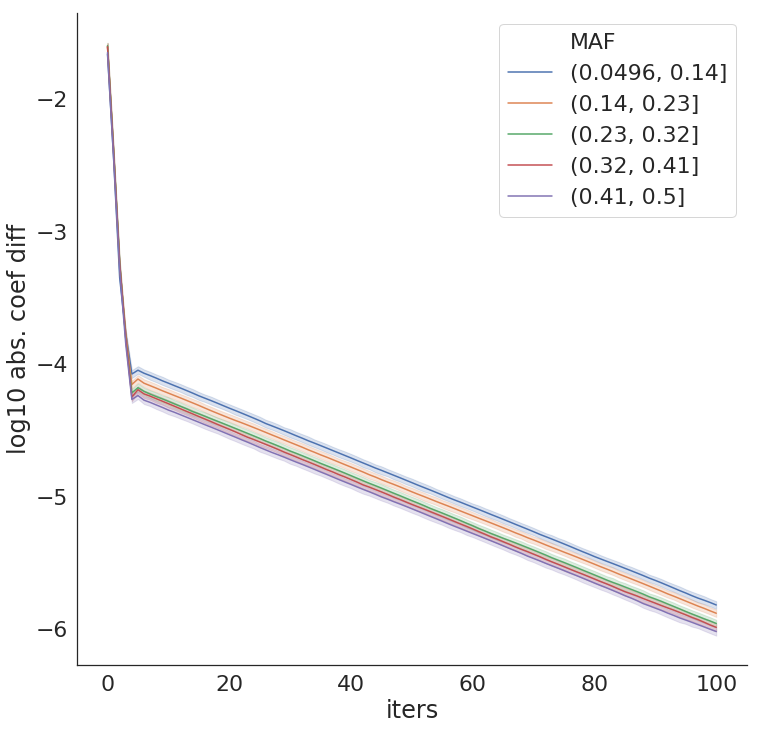

In [42]:
timeSeries['MAF'] = pd.cut(timeSeries.AF, 5)
sns.set(font_scale=2)
sns.set_style("white")
ax = sns.lineplot(data=timeSeries, y='coef', x='iter', hue="MAF")
# ax = sns.lineplot(data=timeSeries, y='mcoef', x='iter', hue="condition", ax=ax,linestyle='--')
sns.despine()
ax.set(ylabel="log10 abs. coef diff", xlabel="iters")
ax.figure.savefig("figures/CC_iters_MAF.pdf")

In [43]:
timeSeries.head()

,coef,pCoef,deltaell,iter,snp,Ccoef,AF,Status,MAF
0,-1.385481,1.000000,-0.469636,0,0,0.041164,0.2391,Non-significant,"(0.23, 0.32]"
1,-2.176577,0.260443,-0.469636,1,0,0.041164,0.2391,Non-significant,"(0.23, 0.32]"
2,-3.046904,0.343372,-0.469636,2,0,0.041164,0.2391,Non-significant,"(0.23, 0.32]"
3,-3.538845,0.329337,-0.469636,3,0,0.041164,0.2391,Non-significant,"(0.23, 0.32]"
4,-4.021491,0.331606,-0.469636,4,0,0.041164,0.2391,Non-significant,"(0.23, 0.32]"


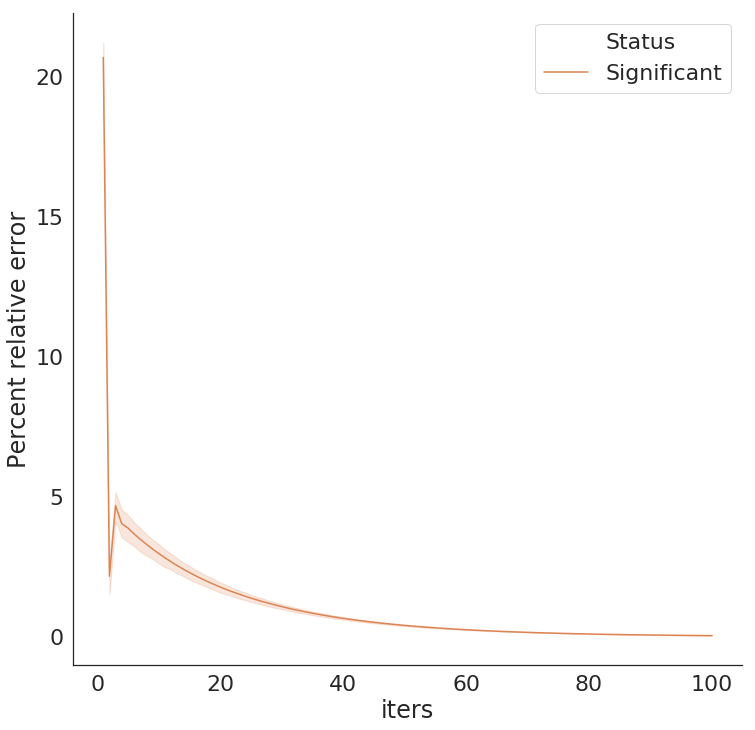

In [44]:
sns.set(font_scale=2)
sns.set_style("white")
rdf = timeSeries[np.logical_and(timeSeries.iter>0, timeSeries.Status=="Significant")]
palette = [sns.color_palette("deep", 7)[1]]
ax = sns.lineplot(data=rdf, y=pow(10,rdf.coef)*100/rdf.Ccoef, x='iter', hue="Status", palette=palette)
sns.despine()
ax.set(ylabel="Percent relative error", xlabel="iters")
ax.figure.savefig("figures/sep_iters_rel.pdf")

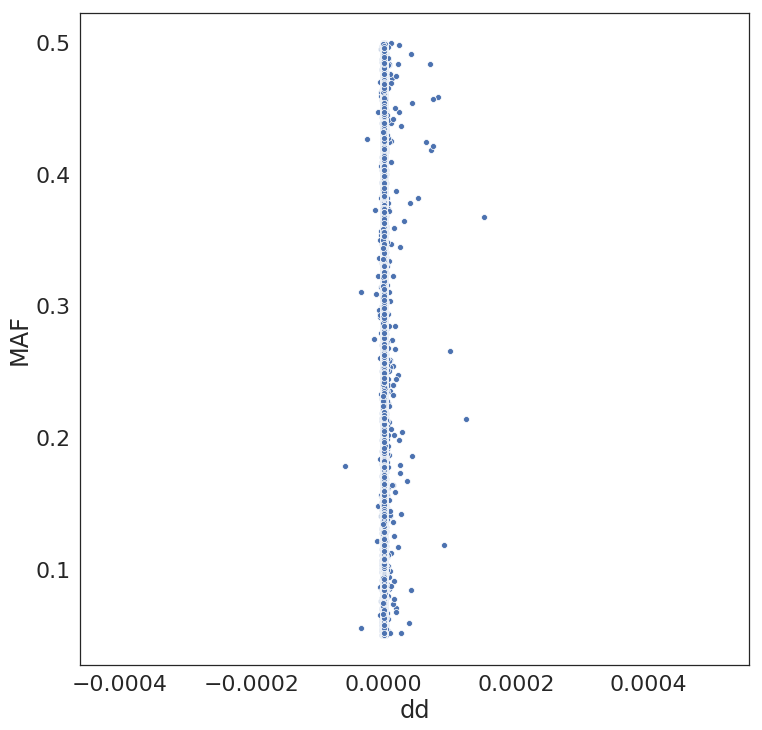

In [45]:
df = pd.DataFrame({})
df['dd'] = ddata.pll - data.pll
df["MAF"] = AF.MAF

sns.scatterplot(data=df, x='dd', y = 'MAF')

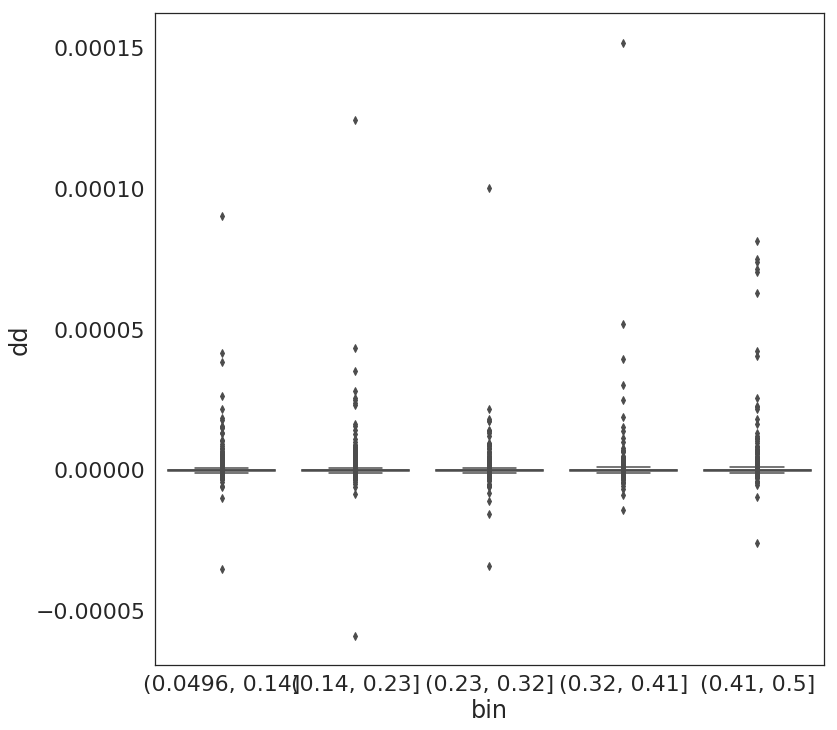

In [46]:
df['bin']  = pd.cut(df.MAF, 5)
sns.boxplot(data=df, y='dd', x='bin')